In [2]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import BaseChronosPipeline

/home/hasith/miniconda3/envs/chronos_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-05-07 23:40:47,638] [WARNING] [real_accelerator.py:194:get_accelerator] Setting accelerator to CPU. If you have GPU or other accelerator, we were unable to detect it.
[2025-05-07 23:40:47,645] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cpu (auto detect)


In [3]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cpu",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
)

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# quantiles is an fp32 tensor with shape [batch_size, prediction_length, num_quantile_levels]
# mean is an fp32 tensor with shape [batch_size, prediction_length]
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df["#Passengers"]),
    prediction_length=12,
    quantile_levels=[0.1, 0.5, 0.9],
)

In [6]:
mean.shape

torch.Size([1, 12])

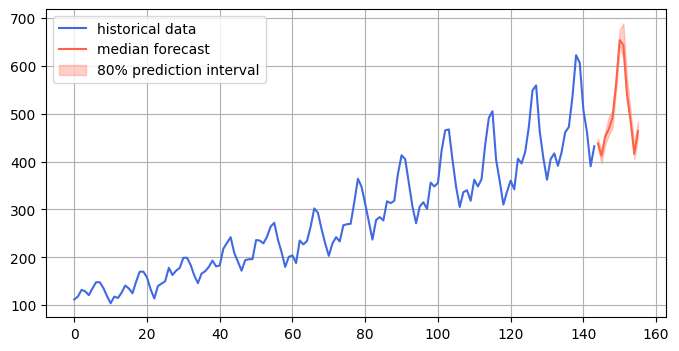

In [10]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib

forecast_index = range(len(df), len(df) + 12)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [11]:
pipeline.model

ChronosModel(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(4096, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(4096, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=512, bias=False)
                (k): Linear(in_features=512, out_features=512, bias=False)
                (v): Linear(in_features=512, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=512, out_features=2048, bias=False)
                (wo): Linear(in_features=